#### This notebook is used to train a character recongition from input image using MobileNets 

In [1]:
# ignore warning 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import numpy as np
import cv2

Using TensorFlow backend.


### Visualize dataset

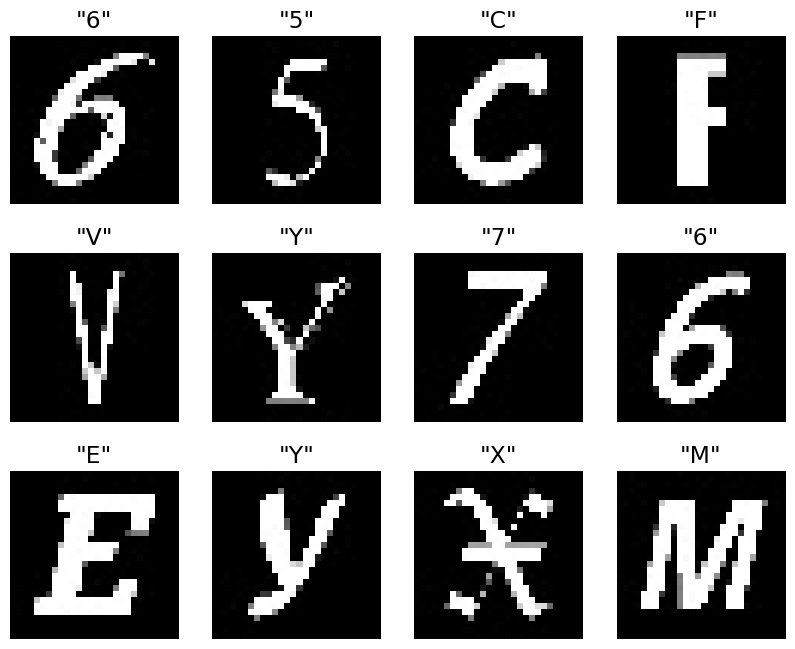

In [2]:
dataset_paths = glob.glob("dataset_characters/**/*.jpg")

cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

plt.savefig("Visualize_dataset.jpg",dpi=300)    


## Data pre-processing

In [3]:
# Arange input data and corresponding labels
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))


# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save('license_character_classes2.npy', lb.classes_)

[INFO] Find 37623 images with 36 classes


In [4]:
# split 10% of data as validation set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

In [5]:
# data augumentation
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

## Initialize MobileNets architecture with pre-trained weight

In [13]:
# Create our model with pre-trained MobileNetV2 architecture from imagenet
from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50


def create_model(lr=1e-4,decay=1e-4/25, training=False,output_shape=y.shape[1]):
    # baseModel = VGG16(weights="imagenet", 
    #                         include_top=False,
    #                         input_tensor=Input(shape=(80, 80, 3)))
    baseModel = ResNet50(weights='imagenet', include_top=False, input_shape=(80, 80, 3))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(output_shape, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    if training:
        # define trainable lalyer
        for layer in baseModel.layers:
            layer.trainable = True
        # compile model
        optimizer = Adam(lr=lr, decay = decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
        
    return model

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import functions
# Özellik vektörleri ve etiketler için boş listeler oluşturun



In [ ]:

pictures_file_path = "test"  

wpod_net_path = "wpod-net.json"
wpod_net = functions.load_model(wpod_net_path)

temp_arr=[]
final_string=""
predicted_plates = []
actual_plates = []

model_char='MobileNets_character_recognition.json'
model_Weight="License_character_recognition_weight.h5"
model_class='license_character_classes.npy'
model,labels=functions.load_train_model(model_char,model_Weight,model_class)



for filename in os.listdir(pictures_file_path):
    tempPath=os.path.join(pictures_file_path,filename)
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        vehicle, LpImg,cor =functions.get_plate(tempPath,wpod_net)
        
        #visualize vehicles
        #visualize_functions.draw_vehicle(vehicle,LpImg)
        
        if (len(LpImg)): #check if there is at least one license image
            plate_image, gray, blur, binary,thre_mor=functions.morph_pictures(LpImg)
            #plate_text=functions.configure_file_name(blur,pictures_file_path,filename)

   
# visualize results    
        #visualize_functions.draw_morphed_plates(plate_image, gray, blur, binary,thre_mor)
    
        crop_characters =functions.segment_characters(plate_image)

      

features = []
labels = []

crop_characters =functions.segment_characters(plate_image)

# crop_characters listesini dönerek özellikleri ve etiketleri toplayın
for char_image in crop_characters:
    # Karakter görüntüsünü özellik vektörü olarak kullanabilirsiniz
    # Örnek olarak, karakter görüntüsünü düzleştirerek (flatten) bir özellik vektörü elde edebilirsiniz
    feature_vector = char_image.flatten()
    
    # feature_vector'ü features listesine ekleyin
    features.append(feature_vector)
    
    # Karakterin gerçek değerini (etiket) labels listesine ekleyin
    # Örnek olarak, karakterin gerçek değerini elde etmek için kullanabilirsiniz
    label = get_label_from_image(char_image)
    labels.append(label)

# Listeleri NumPy dizilerine dönüştürün
features = np.array(features)
labels = np.array(labels)

# Veri setini eğitim ve test alt kümelerine ayırın
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

            
            

    
    # Tahmin edilen plaka ve gerçek plaka listelere eklenir
    
    
  


In [14]:
# initilaize initial hyperparameter
INIT_LR = 1e-4
EPOCHS = 2

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

94765736/94765736 [==============================] - 37s 0us/step


c:\Users\barra\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Train model

In [22]:
BATCH_SIZE = 128


my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(filepath="ResNet50_License_character_recognition2.h5", verbose=1, save_weights_only=True)
                ]

result = model.fit(image_gen.flow(trainX, trainY, batch_size=BATCH_SIZE), 
                   steps_per_epoch=len(trainX) // BATCH_SIZE, 
                   validation_data=(testX, testY), 
                   validation_steps=len(testX) // BATCH_SIZE, 
                   epochs=EPOCHS, callbacks=my_checkpointer)

Epoch 1/2
  3/264 [..............................] - ETA: 28:42 - loss: 2.3991 - accuracy: 0.3333

KeyboardInterrupt: 

## Visualize training result

NameError: name 'result' is not defined

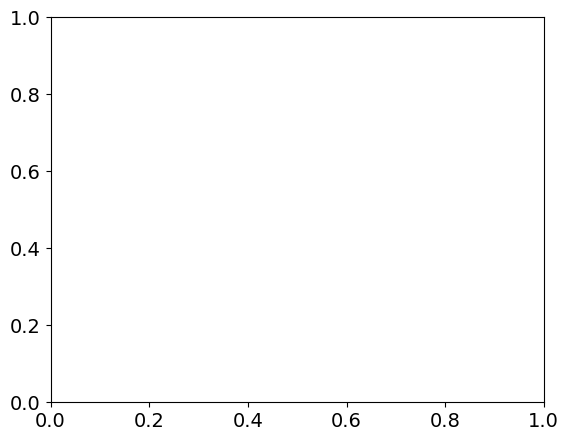

In [16]:

fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
print(result.history['accuracy'],result.history['val_accuracy'])
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
print(result.history)
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#plt.savefig("Training_result.jpg",dpi=300)

In [ ]:
# save model architectur as json file
model_json = model.to_json()
with open("ResNet50_character_recognition.txt", "w") as json_file:
  json_file.write(model_json)

## The End!